## Pre_procesamiento texto de homicidios
1. converting words to lower/upper case
2. removing special characters
3. removing stopwords and high/low-frequency words ##mirar si en el ner esto es necesario
4. stemming/lemmatization

In [29]:
import pandas as pd
import spacy # python -m spacy download es_core_news_sm 
import numpy as np
import nltk
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
dataset = pd.read_excel("union_vif_ds.xlsx")
dataset = dataset[['arma_medio',  'modalidad_294', 'sexo', 'nivel_academico', 'edad', 'relato', 'reincidente total']].dropna().reset_index(drop=True)

### Preprocesamiento

In [5]:
def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)

    return texto

#funcion para solo dejar letras
def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    
    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)
    
    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

##tokenizar
nlp = spacy.load('es_core_news_sm')
#lemantizacion
def lemantizacion(texto):
    lemmas = [tok.lemma_ for tok in texto]
    return(lemmas)
    

##preprocesamiento basico
def preprocesar(texto):
    texto = limpiar(texto)
    texto = normalizar(texto)
    texto = nlp(texto)
    texto = lemantizacion(texto)

    return texto

In [8]:
# 1. converting words to lower/upper case, 2. removing special characters, 4. stemming/lemmatization
dataset['descripcion_nueva'] = dataset['relato'].apply(lambda x: preprocesar(x))
dataset.descripcion_nueva.head()

0    [el, yo, llamar, al, celular, y, yo, decir, al...
1    [yo, convivo, con, el, hacer, cinco, ano,  , t...
2    [yo, convivo, con, él, desde, el, mes, de, ago...
3    [duber, andr, convivir, con, migo, desde, hace...
4    [él, que, pasar, ser, que, yo, vivir, con, el,...
Name: descripcion_nueva, dtype: object

In [13]:
dataset.descripcion_modelo = dataset['descripcion_nueva'].apply(lambda x: ' '.join(x)) 
dataset.descripcion_modelo.head()

0    el yo llamar al celular y yo decir alexa yo qu...
1    yo convivo con el hacer cinco ano   tener uno ...
2    yo convivo con él desde el mes de agosto de   ...
3    duber andr convivir con migo desde hacer    an...
4    él que pasar ser que yo vivir con el hacer mas...
Name: descripcion_nueva, dtype: object

### Stopwords and high/low frequency words

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
stop_words_sp = stopwords_corpus.words('spanish')
noise_words.extend(stop_words_sp)
print(len(noise_words))
noise_words

[nltk_data] Downloading package stopwords to /root/nltk_data...


313


[nltk_data]   Unzipping corpora/stopwords.zip.


['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [16]:
# create a count vectorizer to create a document-term matrix
vectorizer = CountVectorizer(stop_words= noise_words)
X = vectorizer.fit_transform(dataset.descripcion_modelo)
words = vectorizer.get_feature_names_out()

In [22]:
word_counts = X.sum(axis=0)
word_counts_df = pd.DataFrame(word_counts, columns=words)
word_counts_df = word_counts_df.transpose()
word_counts_df.columns = ['count']
word_counts_df = word_counts_df.sort_values('count', ascending=False)

total_num_words = sum(X.sum(axis=1))
num_tokens = X.sum()
num_unique_words = len(vectorizer.vocabulary_)
avg_tokens_per_doc = num_tokens / num_docs
avg_word_freq = num_tokens / num_unique_words


print(f'Number of words: {total_num_words}')
print(f'Number of tokens: {num_tokens}')
print(f'Number of unique words: {num_unique_words}')
print(f'Average tokens per document: {avg_tokens_per_doc:.2f}')
print(f'Average word frequency: {avg_word_freq:.2f}')


Number of words: [[4212022]]
Number of tokens: 4212022
Number of unique words: 58052
Average tokens per document: 174.32
Average word frequency: 72.56


In [26]:
X

<24163x58052 sparse matrix of type '<class 'numpy.int64'>'
	with 2720171 stored elements in Compressed Sparse Row format>

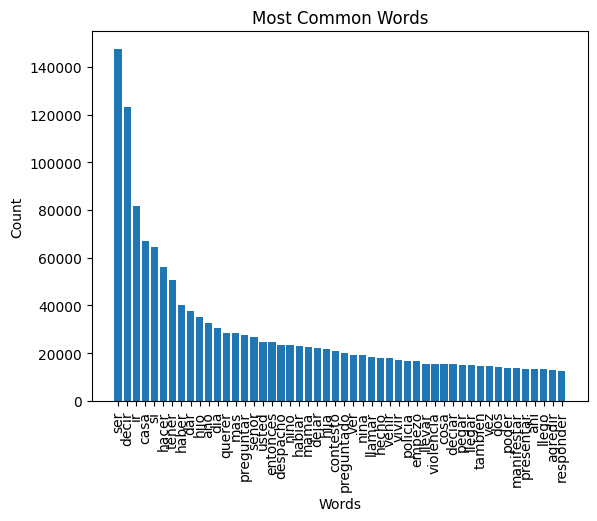

In [25]:
#plot of the most used words
# Get the count of each word in the dataset
word_counts = np.asarray(X.sum(axis=0)).ravel()
words = np.array(words)
word_counts_sorted = np.argsort(word_counts)[::-1]

# Plot the top 20 words by count
num_top_words = 50
plt.bar(np.arange(num_top_words), word_counts[word_counts_sorted[:num_top_words]])
plt.xticks(np.arange(num_top_words), words[word_counts_sorted[:num_top_words]], rotation=90)
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Most Common Words")
plt.show()

In [27]:
y = dataset['reincidente total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4386
           1       0.12      0.03      0.05       447

    accuracy                           0.89      4833
   macro avg       0.51      0.50      0.49      4833
weighted avg       0.84      0.89      0.86      4833



In [31]:
# Get the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[4289   97]
 [ 434   13]]
